In [1]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

In [3]:
with open("../../corpus/NTT/persona.json", "r", encoding="utf-8") as f:
    convs = json.load(f)

In [4]:
import random
random.seed(0)

def make_Xy(convs, n=4, rate=3):

    X_str = []
    y = []

    all_utt = []
    for did in tqdm( convs["convs"] ) :
        dids = list( did.keys() )[0]
        all_utt += did[dids]
    random.shuffle(all_utt)

    j = 0

    for did in tqdm( convs["convs"] ):
        dids = list( did.keys() )[0]
        conv = did[dids]
        # print(conv)
        for i in range(n-1, len(conv)):
            p = (i-n+1)
            # print(i, "[{0}:{1}]".format(p, p+n), conv[p:p+n-1])
            # 正例
            if i%rate != 0:
                X_str.append( conv[p:p+n] )
                y.append(0)
                # print(i, conv[p:p+n])
            # 負例
            else:
                X_str.append( conv[p:p+n-1]+[all_utt[j]] )
                j += 1
                y.append(1)
    
    return X_str, y


In [5]:
# n: 発話長， rate: エラー発話の確率
X_str_topic, y = make_Xy(convs, n=4)

100%|██████████| 5016/5016 [00:00<00:00, 58752.19it/s]


In [6]:
len(X_str_topic[::10])

4674

In [86]:
X_str_topic_ = X_str_topic[::30]
y_ = y[::30]

In [87]:
y_.count(0)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [9]:
from gensim.models import KeyedVectors

[612] 2022-01-02 15:46:53,028 Info gensim.models.keyedvectors :loading projection weights from ../../corpus/w2v/model.vec
[612] 2022-01-02 15:47:55,875 Info gensim.utils :KeyedVectors lifecycle event {'msg': 'loaded (351122, 300) matrix of type float32 from ../../corpus/w2v/model.vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-01-02T15:47:55.875335', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.72-microsoft-standard-WSL2-x86_64-with-Ubuntu-18.04-bionic', 'event': 'load_word2vec_format'}


success save : ../models/context_topic/symbol.pickle


In [12]:
ppmi_dataname = "../../corpus/collocation/ppmi_ntt1"
ppmi_matrix2 = np.load(ppmi_dataname+".npy")

In [13]:
toyoshima_set = set("NOUN PROPN VERB ADJ".split())

def w2v(word, w2v_model:KeyedVectors, SYMBOL_w2v:dict):
    if word in SYMBOL_w2v:
        vector = SYMBOL_w2v[word]
    elif word in w2v_model:
        vector = w2v_model[word]
    else:
        vector = SYMBOL_w2v["[UNK]"]
    return vector

def filtering(doc, filter_set):
    left = []
    for token in doc:
        if token.pos_ in filter_set:
            left.append(token.lemma_)
    return left if len(left)>0 else ["[NONE]"]

def doc2vec(doc, w2v_model:KeyedVectors, SYMBOL_w2v:dict):
    left = filtering(doc, toyoshima_set)
    return np.mean([ w2v(w, w2v_model, SYMBOL_w2v) for w in left], axis=0)

# 副詞など，ほぼすべて
def doc2vec2(doc, w2v_model:KeyedVectors, SYMBOL_w2v:dict):
    left = filtering(doc, independent_set)
    return np.mean([ w2v(w, w2v_model, SYMBOL_w2v) for w in left], axis=0)

def sentence2formated(sen, w2v_model:KeyedVectors, SYMBOL_w2v:dict):
    docs = sentence2docs(sen, sents_span=False)
    vector = [np.zeros(300)]
    for i, doc in enumerate(docs):
        if i==0:
            prev_vector = doc2vec2(doc, w2v_model, SYMBOL_w2v)
        else:
            current_vector = doc2vec2(doc, w2v_model, SYMBOL_w2v)
            diff_vec = np.abs(prev_vector-current_vector)
            norm = np.linalg.norm(diff_vec)
            if norm==0:
                norm = 1            
            # vector.append( diff_vec/norm )
            vector.append( diff_vec)
            prev_vector = current_vector
    return np.array(vector)

In [60]:
topic_x_name = "../X_y_data/context_topic/X_topic_mini"
topic_y_name = "../X_y_data/context_topic/y_topic_mini"

In [74]:
symbol_path = "../models/context_topic/"
symbol_name = "symbol.pickle"
symbolM = DataManager(symbol_path)

if os.path.exists(topic_x_name+".npy"):
    X_topic = np.load(topic_x_name+".npy")
    y = np.load(topic_y_name+".npy")
    print("success load {0}.npy".format(topic_x_name))
    SYMBOL_w2v = symbolM.load_data(symbol_name)
    print("success load {0}".format(symbol_name))
else:
    w2v_path = "../../corpus/w2v/"
    # fasttext
    # https://qiita.com/Hironsan/items/513b9f93752ecee9e670
    w2v_name =  "dep-ja-300dim"
    w2v_name =  "model.vec"
    w2v_model = KeyedVectors.load_word2vec_format(w2v_path+w2v_name)

    wsv_dim = w2v_model["あ"].shape[0]
    add_keys = ["FOS", "EOS", "[SEP]", "[UNK]", "[NONE]"]
    add_weights = [np.random.randn(wsv_dim) for _ in range(len(add_keys))]
    add_weights = [ v/np.linalg.norm(v) for v in add_weights ]
    SYMBOL_w2v = dict(zip(add_keys, add_weights))

    
    symbolM.save_data(symbol_name, SYMBOL_w2v)

    X_topic = []
    for conv in tqdm(X_str_topic_):
        vector = sentence2formated(conv, w2v_model, SYMBOL_w2v)
        X_topic.append(vector)
    X_topic = np.array(X_topic)
    

success load ../X_y_data/context_topic/X_topic_mini.npy
success load : ../models/context_topic/symbol.pickle
success load symbol.pickle


In [90]:
y_.shape

(1558,)

In [75]:
np.save(topic_x_name, X_topic)
np.save(topic_y_name, y)

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size, vocab_dict):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim,  padding_idx=0)
        # モデルを2つ定義
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        # self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.hidden2tag = nn.Linear(hidden_dim , tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()
    
        self.vocab_dict = vocab_dict
    
    def forward(self, x):
        emb1 = self.word_embeddings(x)
        _, lstm1_out = self.lstm1(emb1)
        tag_space = self.hidden2tag(torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 ))
        y =self.softmax(tag_space)
        return y
    
    def last_context(self, x):
        emb1 = self.word_embeddings(x)
        # print(emb1.shape)
        _, lstm1_out = self.lstm1(emb1)
        context = torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 )
        return context
    
    def text2context(self, text):
        if isinstance(text, str):
            utt_id = self._sentence2ids(text, self.vocab_dict)
            utt_id_tensor = torch.tensor( [utt_id] , device='cuda:0', dtype=torch.int)
            # utt_id_tensor = torch.tensor( [utt_id] , device='cpu', dtype=torch.int)
            return self.last_context(utt_id_tensor)
        if isinstance(text, list):
            X = self._make_X(text, self.vocab_dict)
            utt_id_tensor = X.to(torch.int).cuda()
            # utt_id_tensor = X.to(torch.int)
            return self.last_context(utt_id_tensor)
        else:
            return 0

        
    def _sentence2ids(self, sentence:str, vocab_dict:dict):
        doc = self._sentence2formated(sentence)
        ids = np.zeros(len(doc))
        for i, key in enumerate(doc):
            # key = token.orth_
            if key in vocab_dict:
                ids[i] = vocab_dict[key]
            else:
                ids[i] = vocab_dict["[UNK]"]
        return ids
    
    def _sentence2formated(self, sen):
        return sum( fill_SYMBOL_ONE( sentence2normalize_noun(sen) ), [] )
    
    def _padding_vector(self, Xseq):
        Xseq = [ torch.tensor( xseq[:, None] ) for xseq in Xseq]
        Xseq = rnn.pad_sequence(Xseq, batch_first=True)
        Xseq = [ torch.flatten(xseq) for xseq in Xseq ] 
        return Xseq


    def _make_X(self, utt_list:list, vocab_dict:dict):
        utt_id_list = []
        for utt in tqdm( utt_list) :
            utt_id = self._sentence2ids(utt, vocab_dict)
            utt_id_list.append(utt_id)

        utt_id_pad = self._padding_vector(utt_id_list)
        upl = len(utt_id_pad[0])
        # X =   [ torch.Tensor([u, s]) for u, s in zip(usr_id_pad, sys_id_pad) ] 
        # print(usr_pad_len, sys_pad_len)
        X = torch.zeros( (len(utt_list), upl) )
        for i, u in enumerate(utt_id_pad):
            X[i, :upl] = u
        return X

In [27]:
model_path = "../models/response2/"
model_name = "forward_v2.pickle"
modelM = DataManager(model_path)
fmodel = modelM.load_data(model_name)

success load : ../models/response2/forward_v2.pickle


In [19]:
# 機能ベクトルの特徴量化
X_forward_all_str = sum(X_str_topic_, [])

In [67]:
forward_xy_name = "../X_y_data/context_topic/X_forward_mini_id"

In [72]:
if os.path.exists(forward_xy_name+".npy"):
    X_forward_ids  = np.load(forward_xy_name+".npy")
    print("success load {0}.npy".format(forward_xy_name))
else:
    with torch.no_grad():
    # X_forward_l =  fmodel.text2context(X_forward_all_str[:50])
        # 手で書くしかない
        fmodel.cpu()
        x_length = len(X_str_topic_)
        X_forward_ids = fmodel._make_X(X_forward_all_str, fmodel.vocab_dict).to(torch.int)
        X_forward_ids = X_forward_ids.reshape(x_length, 4, -1).numpy()
        # X_forward = fmodel.last_context(X_forward_ids).numpy()
        # X_forward = X_forward.reshape(-1, 4, 256)
        fmodel.cuda()
        # X_forward_l = np.array( fmodel.text2context(X_forward_all_str).cpu() ) 
        

success load ../X_y_data/context_topic/X_forward_mini_id.npy


In [69]:
x_length = len(X_str_topic_)
X_forward_ids = X_forward_ids.reshape(x_length, 4, -1).numpy()

In [70]:
np.save(forward_xy_name, X_forward_ids)

In [73]:
X_forward_ids.shape

(1558, 4, 75)

In [81]:
X_n = np.concatenate([X_topic, X_forward_ids], axis=2)
X = torch.from_numpy(X_n)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.30, random_state=5, stratify=y_)

In [62]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [192]:
import copy
class TopicClassifier(nn.Module):
    def __init__(self, topic_dim, id_len, forward_dim,  hidden_dim, tagset_size, fmodel_path="../models/response2/"):
        # 親クラスのコンストラクタ。決まり文句
        super(TopicClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.tlen = topic_dim
        self.idlen = id_len
        self.flen = forward_dim
        self.hidden = hidden_dim
        self.tlstm = nn.LSTM(topic_dim, hidden_dim, batch_first=True)
        self.lay2_lstm = nn.LSTM(hidden_dim+forward_dim, hidden_dim, batch_first=True)
        self.hid2out = nn.Linear(hidden_dim , tagset_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax()

        fmodel_name = "forward_v2.pickle"
        modelM = DataManager(fmodel_path)
        self.fmodel = modelM.load_data(fmodel_name)

    def forward(self, x):
        x_topic = x[:, :, :self.tlen].to(torch.float)
        x_forward_id = x[:, :, self.tlen:].to(torch.int)
        # print(x_topic.shape)

        forward_c = torch.stack( [ self.fmodel.last_context(xfid) for xfid in x_forward_id])
        topic_out, _ = self.tlstm(x_topic)

        # print("forward_c: ", forward_c.shape, "topic_out: ", topic_out.shape)
        x_lay2 = torch.cat([forward_c, topic_out], dim=2)
        # print("x_lay2: ", x_lay2.shape)

        _, hc = self.lay2_lstm(x_lay2)
        out = self.hid2out(hc[0][0])
        y = self.softmax(out)

        # print("hc: ",len(hc),  hc[0][0].shape)
        
        return y

In [193]:
BATCH_SIZE = 32
epoch_ = 300
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [194]:
TOPIC_DIM = 300
ID_LEN = 75
FORWARD_DIM = 256
HIDDEN_DIM = TOPIC_DIM//2
OUTPUT_DIM = 2

In [195]:
model = TopicClassifier(TOPIC_DIM, ID_LEN, FORWARD_DIM, HIDDEN_DIM, OUTPUT_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

success load : ../models/response2/forward_v2.pickle


In [196]:
model(X[:3].cuda())

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-0.7503, -0.6391],
        [-0.7394, -0.6489],
        [-0.7448, -0.6440]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [198]:
losses = []
for epoch in tqdm( range(epoch_)  ):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0', dtype=torch.int16)
        X_t_tensor = data[0].cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape , y_t_tensor.view(-1,1).shape)

        score = model(X_t_tensor)
        # print(X_t_tensor.shape, score.view(-1,5).shape, y_t_tensor.view(-1,1).shape)
        loss_ = loss_function(score,  y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 20 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

  7%|▋         | 20/300 [28:57<6:43:58, 86.57s/it]

epoch 20 	 loss 0.01004382390237879


 13%|█▎        | 40/300 [58:01<6:15:41, 86.70s/it]

epoch 40 	 loss 0.00231717195129022


 20%|██        | 60/300 [1:26:57<5:48:20, 87.08s/it]

epoch 60 	 loss 0.0008760984319309273


 24%|██▍       | 72/300 [1:45:46<5:34:57, 88.15s/it]


KeyboardInterrupt: 

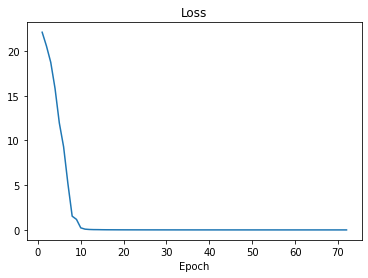

In [199]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [200]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0')
    y_tensor = torch.tensor(y_test, device='cuda:0', dtype=torch.long)
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [202]:
def score(test, pred):
    if len(collections.Counter(pred)) <= 2:
        print('confusion matrix = \n', confusion_matrix(y_true=test, y_pred=pred))
        print('accuracy = ', accuracy_score(y_true=test, y_pred=pred))
        print('precision = ', precision_score(y_true=test, y_pred=pred))
        print('recall = ', recall_score(y_true=test, y_pred=pred))
        print('f1 score = ', f1_score(y_true=test, y_pred=pred))
    else:
        print('confusion matrix = \n', confusion_matrix(y_true=test, y_pred=pred))
        print('accuracy = ', accuracy_score(y_true=test, y_pred=pred))

In [203]:
score(y_test, y_pred)

confusion matrix = 
 [[222  77]
 [ 88  81]]
accuracy =  0.6474358974358975
precision =  0.5126582278481012
recall =  0.47928994082840237
f1 score =  0.4954128440366972
